In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
df = pd.read_csv('CAMRESSTGA01-lvm1.csv', header=None)
df.columns = ['Timestamp', 'Hostname', 'DiskNumber', 'Type', 'Offset', 'Size', 'ResponseTime']
df['Timestamp'] = df['Timestamp'].astype(np.int64)
df = df.sort_values(by='Timestamp')

In [3]:
file_pool_size = df.drop_duplicates(['Offset'])['Size'].sum()
total_request_byte = df['Size'].sum()
total_request_count = df.shape[0]


In [4]:
def make_requests():
    for row in df.itertuples():
        yield getattr(row, 'Offset'), getattr(row, 'Size')

In [5]:
class Server:  # 服务器(cache)
    def __init__(self, space):
        self.space = space  # cache大小
        self.remain = space  # cache剩余空间
        self.cache = OrderedDict()  # OrderDict() 模拟cache LRU方法
        self.hit_count = 0  # 命中次数
        self.hit_byte = 0
        self.miss_count = 0  # 未命中次数
        self.miss_byte = 0

    def _hit(self, fid, size):
        self.hit_count += 1
        self.hit_byte += size
        self.cache.move_to_end(fid)

    def _miss(self, fid, size):
        self.miss_count += 1
        self.miss_byte += size
        while self.remain < size:
            self.remain += self.cache.popitem(last=False)[-1]  # pop出第一个item
        self.cache[fid] = size
        self.remain -= size

    def handle(self, fid, size):  # 处理一次请求
        if fid in self.cache.keys():
            self._hit(fid, size)
        else:
            self._miss(fid, size)

    def hit_rate(self):
        try:
            return self.hit_count / (self.hit_count + self.miss_count)
        except:
            return "Server has not been requested yet!"

    def byte_hit_rate(self):
        try:
            return self.hit_byte / (self.hit_byte + self.miss_byte)
        except:
            return "Server has not been requested yet!"

In [6]:
class Dispatcher1:
    def __init__(self, cache_size, cache_number, simple=True):
        self.cache_number = cache_number
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                fid = getattr(row, 'Offset')
                self.file_mapper[fid] = (fid // 10000 % 1000000) & 0b11111 % cache_number

    def load_balance(self, fid, size):
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
            self.small_caches_heat[self.file_mapper[fid]] += size
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server
        self.big_cache.handle(fid, size)

    def simple_hash(self, fid, size):
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [7]:
class Dispatcher2:
    def __init__(self, cache_size, cache_number, simple=True):
        self.cache_number = cache_number
        self.big_cache = Server(cache_size * cache_number)
        self.small_caches = []
        for i in range(cache_number):
            server = Server(cache_size)
            self.small_caches.append(server)
        self.small_caches_heat = [0] * cache_number
        if simple:
            self.handle_requests = self.simple_hash
        else:
            self.handle_requests = self.load_balance
            self.file_mapper = {}
            for row in df.drop_duplicates(['Offset']).itertuples():
                fid = getattr(row, 'Offset')
                self.file_mapper[fid] = (fid // 10000 % 1000000) & 0b11111 % cache_number

    def load_balance(self, fid, size):
        server = self.file_mapper[fid]
        if fid in self.small_caches[server].cache.keys():
            self.small_caches[server].handle(fid, size)
        else:
            server = self.small_caches_heat.index(min(self.small_caches_heat))
            self.small_caches[server].handle(fid, size)
            self.file_mapper[fid] = server
        self.small_caches_heat[server] += size
        self.big_cache.handle(fid, size)

    def simple_hash(self, fid, size):
        self.small_caches[(fid // 10000 % 1000000) & 0b11111 % self.cache_number].handle(fid, size)

In [8]:
FILE_NUM = len(df['Offset'].value_counts())
CACHE_NUMBER = 4
print(FILE_NUM)
print(CACHE_NUMBER)

dispatcher1_small_server_hit_byte_ratio = []
dispatcher2_small_server_hit_byte_ratio = []
big_server_hit_byte_ratio = []
heat1 = []
heat2 = []
hit_ratio1 = []
hit_ratio2 = []
hit_ratio_big = []
small_hit_ratio1 = []
small_hit_ratio2 = []
time_array = []
cache_size_array = []

cache_size_range = [256000000, 512000000, 1024000000, 2048000000, 4096000000, 8192000000, 16384000000]

small_cache_count_hit_ratio = []
small_cache_byte_hit_ratio = []

1432044
4


In [9]:
for cache_size in cache_size_range:

    print(cache_size)

    cache_size_array.append(cache_size / 1000000)
    dispatcher1 = Dispatcher1(cache_size, CACHE_NUMBER, False)
    dispatcher2 = Dispatcher2(cache_size, CACHE_NUMBER, False)
    time = 0
    for fid, size in tqdm(make_requests()):
        dispatcher1.handle_requests(fid, size)
        dispatcher2.handle_requests(fid, size)
        time += 1
        if cache_size == 16384000000 and time % 100 == 0:
            time_array.append(time)
            heat1.append(dispatcher1.small_caches_heat)
            heat2.append(dispatcher2.small_caches_heat)

            hit_ratio_big.append(dispatcher1.big_cache.hit_byte / (dispatcher1.big_cache.hit_byte + dispatcher1.big_cache.miss_byte))
            hit_ratio1.append(sum([i.hit_byte for i in dispatcher1.small_caches]) / (dispatcher1.big_cache.hit_byte + dispatcher1.big_cache.miss_byte))
            hit_ratio2.append(sum([i.hit_byte for i in dispatcher2.small_caches]) / (dispatcher2.big_cache.hit_byte + dispatcher2.big_cache.miss_byte))
            small_hit_ratio1.append([i.byte_hit_rate() for i in dispatcher1.small_caches])
            small_hit_ratio2.append([i.byte_hit_rate() for i in dispatcher2.small_caches])

    dispatcher1_small_server_hit_byte_ratio.append(sum([i.hit_byte for i in dispatcher1.small_caches]) / (dispatcher1.big_cache.hit_byte + dispatcher1.big_cache.miss_byte))
    dispatcher2_small_server_hit_byte_ratio.append(sum([i.hit_byte for i in dispatcher2.small_caches]) / (dispatcher2.big_cache.hit_byte + dispatcher2.big_cache.miss_byte))
    big_server_hit_byte_ratio.append(dispatcher1.big_cache.hit_byte / (dispatcher1.big_cache.hit_byte + dispatcher1.big_cache.miss_byte))

256000000


2196861it [00:19, 113226.47it/s]


512000000


2196861it [00:21, 103020.80it/s]


1024000000


2196861it [00:20, 106307.19it/s]


2048000000


2196861it [00:19, 111071.93it/s]


4096000000


2196861it [00:20, 108842.15it/s]


8192000000


2196861it [00:20, 105817.17it/s]


16384000000


2196861it [00:22, 97605.24it/s] 


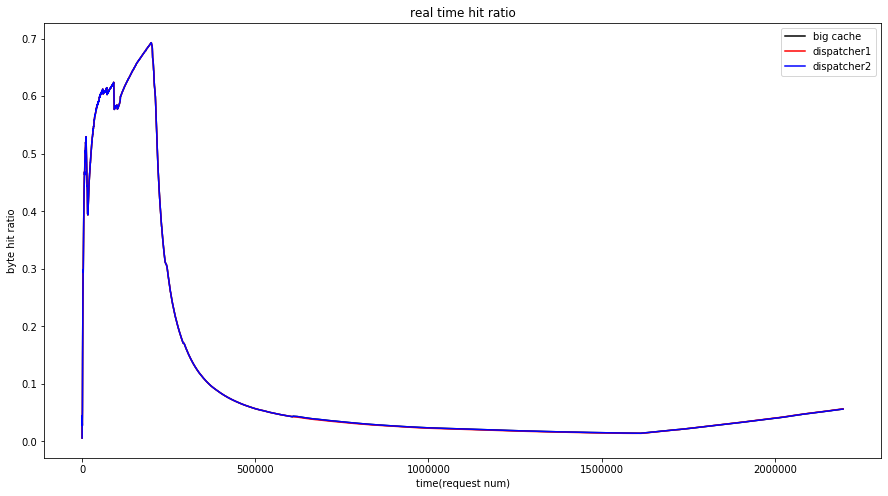

In [11]:
# 查看实时命中率
plt.figure(figsize=(15,8))
plt.plot(time_array, hit_ratio_big, color='black', label='big cache')
plt.plot(time_array, hit_ratio1, color='red', label='dispatcher1')
plt.plot(time_array, hit_ratio2, color='blue', label='dispatcher2')
plt.xlabel("time(request num)")
plt.ylabel("byte hit ratio")
plt.title('real time hit ratio')
plt.legend()
plt.show()

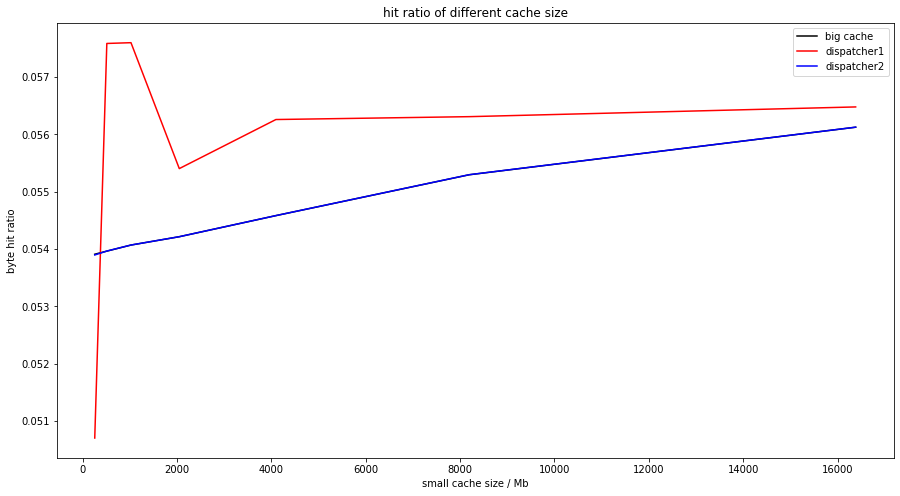

In [12]:
#查看命中率与cache大小的关系
plt.figure(figsize=(15,8))
plt.plot(cache_size_array, big_server_hit_byte_ratio, color='black', label='big cache')
plt.plot(cache_size_array, dispatcher1_small_server_hit_byte_ratio, color='red', label='dispatcher1')
plt.plot(cache_size_array, dispatcher2_small_server_hit_byte_ratio, color='blue', label='dispatcher2')
plt.xlabel("small cache size / Mb")
plt.ylabel("byte hit ratio")
plt.title("hit ratio of different cache size")
plt.legend()
plt.show()

In [13]:
colors = ['blue', 'green', 'pink', 'brown']

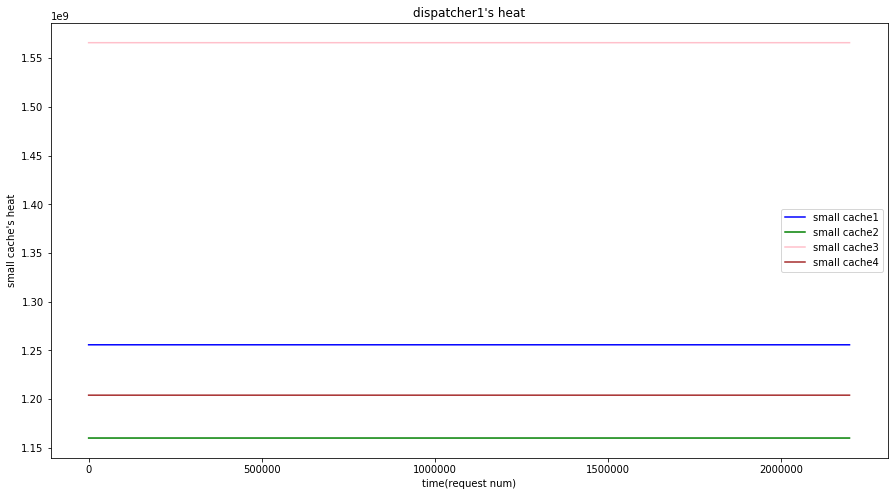

In [14]:
# dispatcher1中小cache热度实时变化情况
plt.figure(figsize=(15,8))
for i in range(4):
    plt.plot(time_array, [j[i] for j in heat1], color=colors[i], label='small cache'+str(i+1))
plt.xlabel("time(request num)")
plt.ylabel("small cache's heat")
plt.title("dispatcher1's heat")
plt.legend()
plt.show()

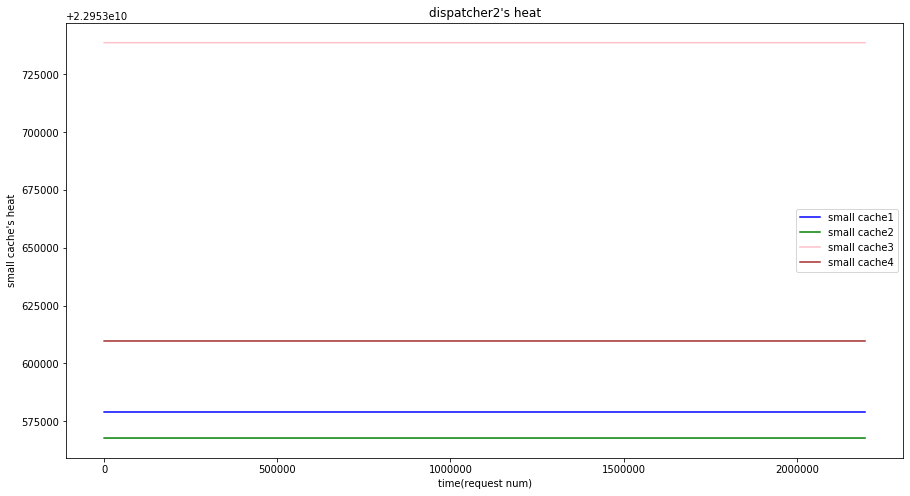

In [15]:
# dispatcher2中小cache热度实时变化情况
plt.figure(figsize=(15,8))
for i in range(4):
    plt.plot(time_array, [j[i] for j in heat2], color=colors[i], label='small cache'+str(i+1))
plt.xlabel("time(request num)")
plt.ylabel("small cache's heat")
plt.title("dispatcher2's heat")
plt.legend()
plt.show()

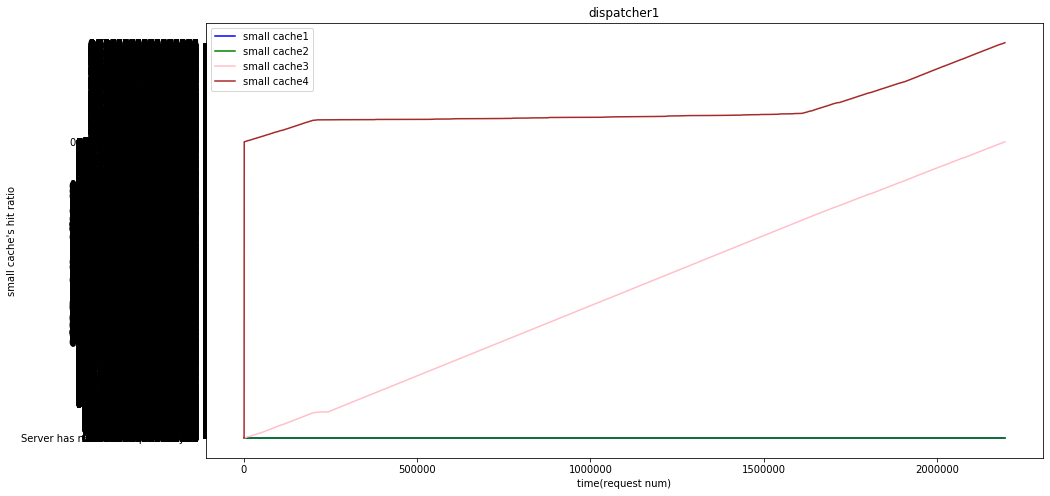

In [19]:
## dispatcher1中小cache命中率实时变化情况
plt.figure(figsize=(15,8))
for i in range(4):
    plt.plot(time_array, [j[i] for j in small_hit_ratio1], color=colors[i], label='small cache'+str(i+1))
plt.xlabel("time(request num)")
plt.ylabel("small cache's hit ratio")
plt.title("dispatcher1")
plt.legend()
plt.show()

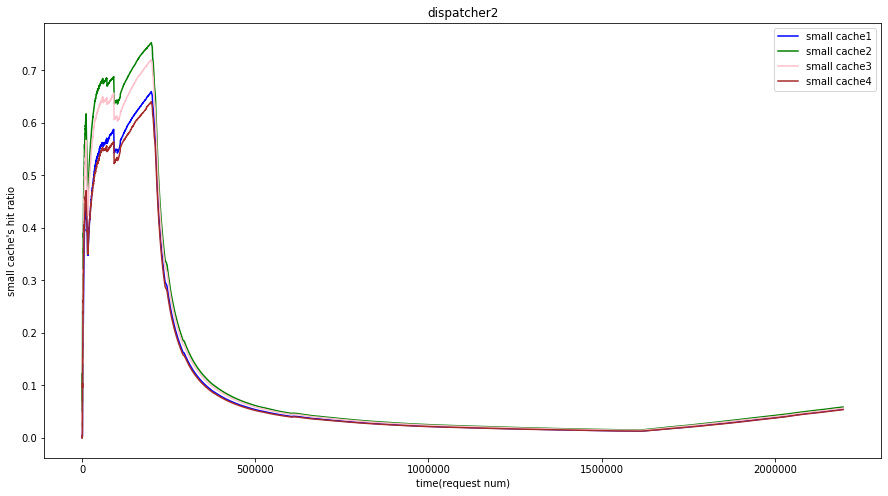

In [17]:
#dispatcher2中小cache命中率实时变化情况
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.plot(time_array, [j[i] for j in small_hit_ratio2], color=colors[i], label='small cache'+str(i+1))
plt.xlabel("time(request num)")
plt.ylabel("small cache's hit ratio")
plt.title("dispatcher2")
plt.legend()
plt.show()
